In [1]:
# Now you can start a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("My Spark Application").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 17:31:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/07 17:31:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count

In [3]:
spark = SparkSession.builder \
    .appName("Use of Force Incidents Preprocessing") \
    .getOrCreate()

24/05/07 17:31:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
use_of_force_incidents = spark.read.csv("NYPD_Use_of_Force_Incidents_20240506.csv", header=True, inferSchema=True)

In [5]:
use_of_force_incidents.select('BasisForEncounter').distinct().show()

+--------------------+
|   BasisForEncounter|
+--------------------+
|    TRANSIT EJECTION|
|CRIME/VIOLATION I...|
|      VTL INFRACTION|
|PAST CRIME/VIOLATION|
|WANTED SUSPECT (E...|
| SUSPICIOUS ACTIVITY|
|   IN CUSTODY INJURY|
|    PERSON IN CRISIS|
|       CROWD CONTROL|
|    AMBUSH OF MEMBER|
|    ANIMAL CONDITION|
|      SEARCH WARRANT|
|  HOSTAGE/BARRICADED|
|          HOME VISIT|
|            PRISONER|
|               OTHER|
|DETECTIVE INVESTI...|
|NON-CRIME CALLS F...|
| ORDER OF PROTECTION|
+--------------------+



In [6]:
use_of_force_incidents.show()

+-------------------+--------------+---------------+------------+--------------+--------------+--------------------+
|TRI Incident Number|     ForceType|Occurrence Date|Incident Pct|Patrol Borough|YearMonthShort|   BasisForEncounter|
+-------------------+--------------+---------------+------------+--------------+--------------+--------------------+
|      2024092962100|Physical Force|     03/23/2024|          73|          PBBN|      2024 Mar|CRIME/VIOLATION I...|
|      2024089962040|Physical Force|     03/19/2024|          70|          PBBS|      2024 Mar|CRIME/VIOLATION I...|
|      2024089962028|Physical Force|     02/20/2024|          70|          PBBS|      2024 Feb|CRIME/VIOLATION I...|
|      2024068962040|Physical Force|     02/09/2024|          49|          PBBX|      2024 Feb|CRIME/VIOLATION I...|
|      2024037962035|Physical Force|     02/07/2024|          18|          PBMS|      2024 Feb|CRIME/VIOLATION I...|
|      2024039962022|Physical Force|     01/31/2024|          20

In [7]:
use_of_force_incidents = use_of_force_incidents.drop("YEARMONTHSHORT")
use_of_force_incidents = use_of_force_incidents.filter(col("PATROL BOROUGH").isNotNull())

In [8]:
borough_mapping = {
    "PBBX": "BRONX", "PBSI": "STATEN ISLAND", "PBMN": "MANHATTAN", "PBMS": "MANHATTAN",
    "PBBN": "BROOKLYN", "PBBS": "BROOKLYN", "PBQS": "QUEENS", "PBQN": "QUEENS"
}

mapping_expr = when(col("PATROL BOROUGH") == 'PBBX', 'BRONX')
for key, value in borough_mapping.items():
    mapping_expr = mapping_expr.when(col("PATROL BOROUGH") == key, value)

use_of_force_incidents = use_of_force_incidents.withColumn("PATROL BOROUGH", mapping_expr.otherwise(col("PATROL BOROUGH")))

In [9]:
use_of_force_incidents.show()

# Getting distinct counts for specific columns
def get_distinct_counts(dataframe, column_name):
    return dataframe.groupBy(column_name).agg(count("*").alias("count")).sort("count", ascending=False)

columns_to_check = ["FORCETYPE", "PATROL BOROUGH"]
for col_name in columns_to_check:
    distinct_counts = get_distinct_counts(use_of_force_incidents, col_name)
    distinct_counts.show()


+-------------------+--------------+---------------+------------+--------------+--------------------+
|TRI Incident Number|     ForceType|Occurrence Date|Incident Pct|PATROL BOROUGH|   BasisForEncounter|
+-------------------+--------------+---------------+------------+--------------+--------------------+
|      2024092962100|Physical Force|     03/23/2024|          73|      BROOKLYN|CRIME/VIOLATION I...|
|      2024089962040|Physical Force|     03/19/2024|          70|      BROOKLYN|CRIME/VIOLATION I...|
|      2024089962028|Physical Force|     02/20/2024|          70|      BROOKLYN|CRIME/VIOLATION I...|
|      2024068962040|Physical Force|     02/09/2024|          49|         BRONX|CRIME/VIOLATION I...|
|      2024037962035|Physical Force|     02/07/2024|          18|     MANHATTAN|CRIME/VIOLATION I...|
|      2024039962022|Physical Force|     01/31/2024|          20|     MANHATTAN|CRIME/VIOLATION I...|
|      2024069962023|Physical Force|     01/26/2024|          50|         BRONX|CR

+--------------------+-----+
|           FORCETYPE|count|
+--------------------+-----+
|      Physical Force|27513|
|   Electrical Weapon| 6451|
|            OC Spray|  611|
|       Impact Weapon|  283|
|             Firearm|  196|
|Restraining Mesh ...|   11|
|       Police Canine|    4|
+--------------------+-----+

+--------------+-----+
|PATROL BOROUGH|count|
+--------------+-----+
|      BROOKLYN|10081|
|         BRONX| 8826|
|     MANHATTAN| 8479|
|        QUEENS| 6182|
| STATEN ISLAND| 1501|
+--------------+-----+



In [10]:
#use_of_force_incidents.write.csv("/content/processed/preprocessed_use_of_force_incidents.csv", header=True, mode="overwrite")

In [11]:
use_of_force_subjects = spark.read.csv("NYPD_Use_of_Force__Subjects.csv", header=True, inferSchema=True)

In [12]:
use_of_force_subjects.show()

+-------------------+--------------------+---------------+----+------------+--------------+-----------------+------------------+
|TRI Incident Number|Subject Injury Level|Subject Injured| Age|Subject Race|Subject Gender|Force Against MOS|Subject Used Force|
+-------------------+--------------------+---------------+----+------------+--------------+-----------------+------------------+
|      2020020962067|           No Injury|              N|NULL|       BLACK|          MALE|   Physical Force|                 Y|
|      2020020962143|           No Injury|              N|NULL|       BLACK|          MALE|   Physical Force|                 Y|
|      2020024962080|           No Injury|              N|NULL|       BLACK|          MALE|   Physical Force|                 Y|
|      2020025962038|           No Injury|              N|NULL|       BLACK|          MALE|   Physical Force|                 Y|
|      2020025962049|           No Injury|              N|NULL|       BLACK|          MALE|   Phy

In [13]:
use_of_force_subjects = use_of_force_subjects.drop("SUBJECT INJURED", "SUBJECT INJURY LEVEL", "SUBJECT USED FORCE")

In [14]:
use_of_force_subjects = use_of_force_subjects.withColumn("SUBJECT GENDER", when(col("SUBJECT GENDER") == "UNK", None).otherwise(col("SUBJECT GENDER")))
use_of_force_subjects = use_of_force_subjects.withColumn(
    "SUBJECT RACE",
    when(col("SUBJECT RACE") == "ASIAN", "ASIAN/PACIFIC ISLANDER")
    .when(col("SUBJECT RACE") == "AMER INDIAN", "AMERICAN INDIAN/ALASKAN NATIVE")
    .otherwise(col("SUBJECT RACE"))
)

In [15]:
#use_of_force_subjects.write.csv("/content/processed/preprocessed_use_of_force_subjects.csv", header=True, mode="overwrite")

In [16]:
use_of_force_combined = use_of_force_incidents.join(
    use_of_force_subjects,
    use_of_force_incidents["TRI INCIDENT NUMBER"] == use_of_force_subjects["TRI INCIDENT NUMBER"],
    how="inner"
)

In [17]:
# Drop the duplicate 'TRI INCIDENT NUMBER' column if it exists
if "TRI Incident Number" in use_of_force_combined.columns:
    use_of_force_combined = use_of_force_combined.drop("TRI Incident Number")

In [18]:
# Print all column names to check for duplicates or renamed duplicates
use_of_force_combined.show()

+--------------+---------------+------------+--------------+--------------------+----+------------+--------------+-----------------+
|     ForceType|Occurrence Date|Incident Pct|PATROL BOROUGH|   BasisForEncounter| Age|SUBJECT RACE|SUBJECT GENDER|Force Against MOS|
+--------------+---------------+------------+--------------+--------------------+----+------------+--------------+-----------------+
|Physical Force|     03/23/2024|          73|      BROOKLYN|CRIME/VIOLATION I...|  21|       BLACK|          MALE|   Physical Force|
|Physical Force|     03/19/2024|          70|      BROOKLYN|CRIME/VIOLATION I...|  27|       BLACK|          NULL|   Physical Force|
|Physical Force|     02/20/2024|          70|      BROOKLYN|CRIME/VIOLATION I...|  36|       BLACK|          MALE|   Physical Force|
|Physical Force|     02/09/2024|          49|         BRONX|CRIME/VIOLATION I...|  13|       BLACK|          MALE|   Physical Force|
|Physical Force|     02/07/2024|          18|     MANHATTAN|CRIME/VIO

In [19]:
# Write the final DataFrame to CSV, ensuring there are no duplicate columns
#use_of_force_combined.write.csv("/content/processed/merged_use_of_force_data.csv", header=True, mode="overwrite")

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

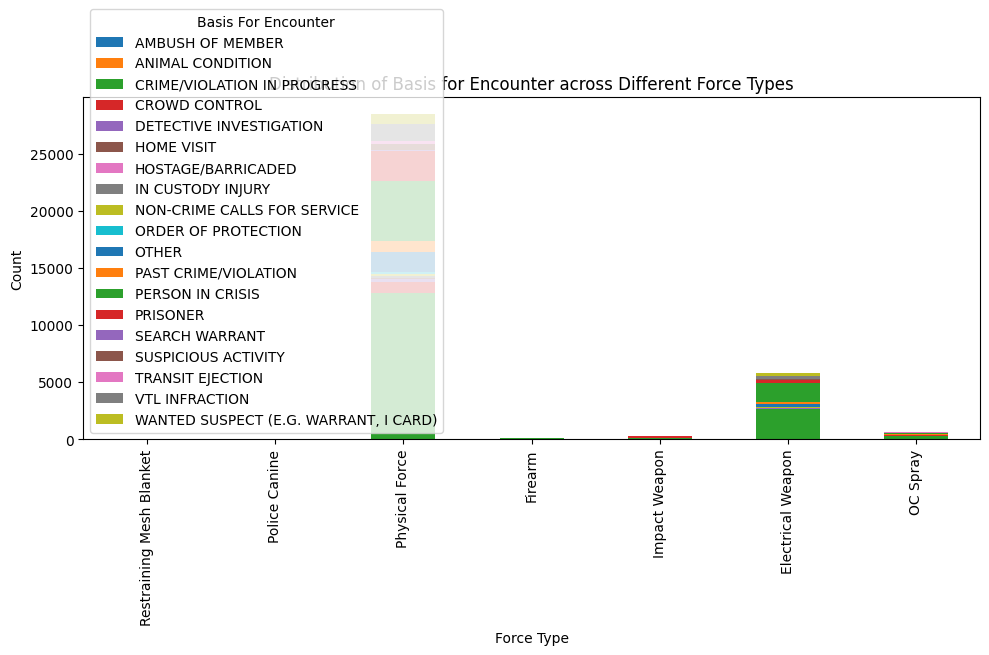

In [21]:
# Group by 'ForceType' and 'BasisForEncounter', count occurrences
grouped_df = use_of_force_combined.groupBy('ForceType', 'BasisForEncounter').count().orderBy('ForceType')

# Pivot the DataFrame
pivot_df = grouped_df.groupBy('ForceType').pivot('BasisForEncounter').sum('count').fillna(0)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pivot_df_pd = pivot_df.toPandas()

# Plotting
pivot_df_pd.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Basis for Encounter across Different Force Types')
plt.xlabel('Force Type')
plt.ylabel('Count')
plt.xticks(range(len(pivot_df_pd['ForceType'])), pivot_df_pd['ForceType'])
plt.legend(title='Basis For Encounter')
plt.tight_layout()
plt.show()

In [22]:
unique_races = use_of_force_combined.select('FORCE AGAINST MOS').distinct().collect()
unique_races

[Row(FORCE AGAINST MOS='No Force'),
 Row(FORCE AGAINST MOS='Cutting Instrument'),
 Row(FORCE AGAINST MOS='Physical Force'),
 Row(FORCE AGAINST MOS='Firearm'),
 Row(FORCE AGAINST MOS='Displayed Weapon'),
 Row(FORCE AGAINST MOS='Impact Weapon')]

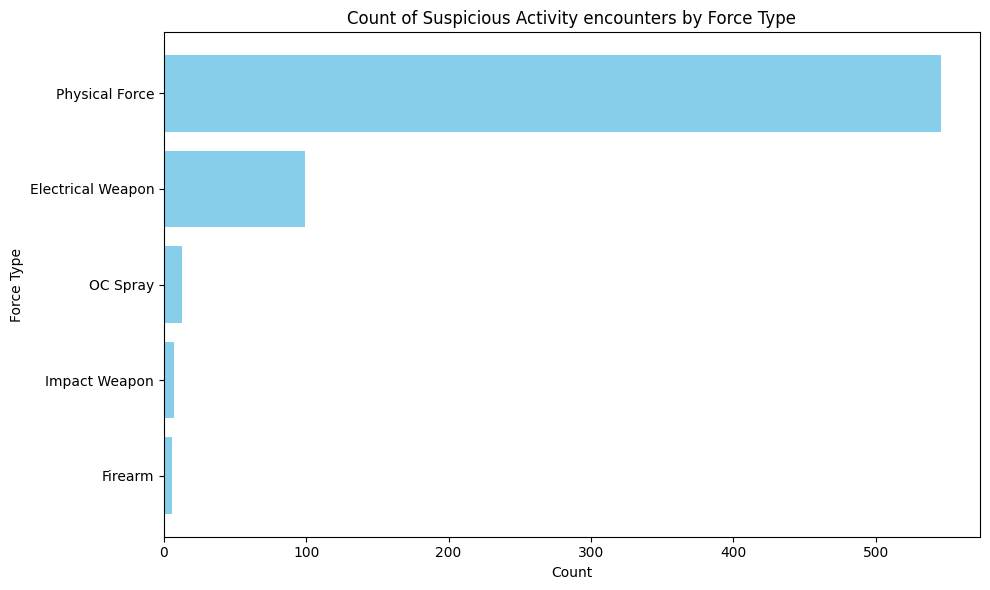

In [23]:
# Filter the DataFrame to include only rows with 'BasisForEncounter' as 'Suspicious Activity'
suspicious_activity_df = use_of_force_combined.filter(use_of_force_combined['BasisForEncounter'] == 'SUSPICIOUS ACTIVITY')
# Group by 'ForceType' and count occurrences
force_type_counts = suspicious_activity_df.groupBy('ForceType').count().orderBy('count')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
force_type_counts_pd = force_type_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(force_type_counts_pd['ForceType'], force_type_counts_pd['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Force Type')
plt.title('Count of Suspicious Activity encounters by Force Type')
plt.tight_layout()
plt.show()

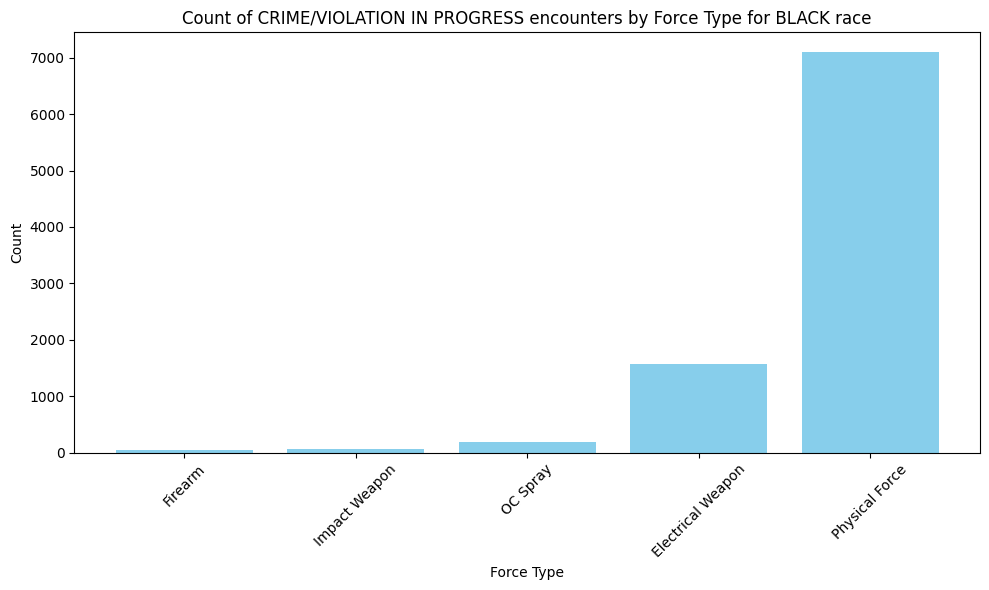

In [24]:
# Filter the DataFrame for race type as 'BLACK' and basis of occurrence as 'SUSPICIOUS ACTIVITY'
filtered_df = use_of_force_combined.filter((col('SUBJECT RACE') == 'BLACK') & (col('BasisForEncounter') == 'CRIME/VIOLATION IN PROGRESS'))

# Group by 'ForceType' and count occurrences
force_type_counts = filtered_df.groupBy('ForceType').count().orderBy('count')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
force_type_counts_pd = force_type_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(force_type_counts_pd['ForceType'], force_type_counts_pd['count'], color='skyblue')
plt.xlabel('Force Type')
plt.ylabel('Count')
plt.title('Count of CRIME/VIOLATION IN PROGRESS encounters by Force Type for BLACK race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

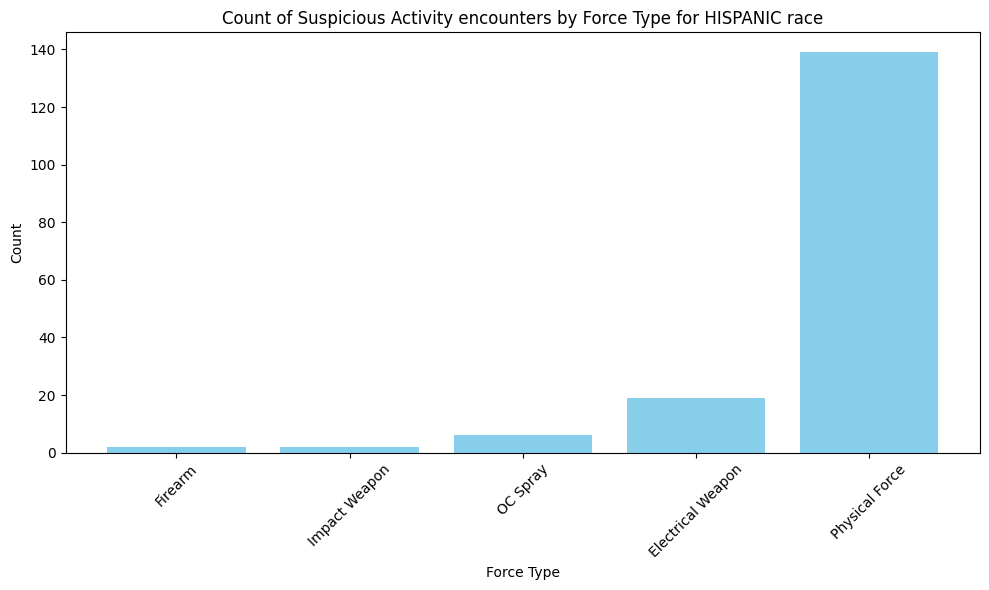

In [25]:
# Filter the DataFrame for race type as 'BLACK' and basis of occurrence as 'SUSPICIOUS ACTIVITY'
filtered_df = use_of_force_combined.filter((col('SUBJECT RACE') == 'HISPANIC') & (col('BasisForEncounter') == 'SUSPICIOUS ACTIVITY'))

# Group by 'ForceType' and count occurrences
force_type_counts = filtered_df.groupBy('ForceType').count().orderBy('count')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
force_type_counts_pd = force_type_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(force_type_counts_pd['ForceType'], force_type_counts_pd['count'], color='skyblue')
plt.xlabel('Force Type')
plt.ylabel('Count')
plt.title('Count of Suspicious Activity encounters by Force Type for HISPANIC race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

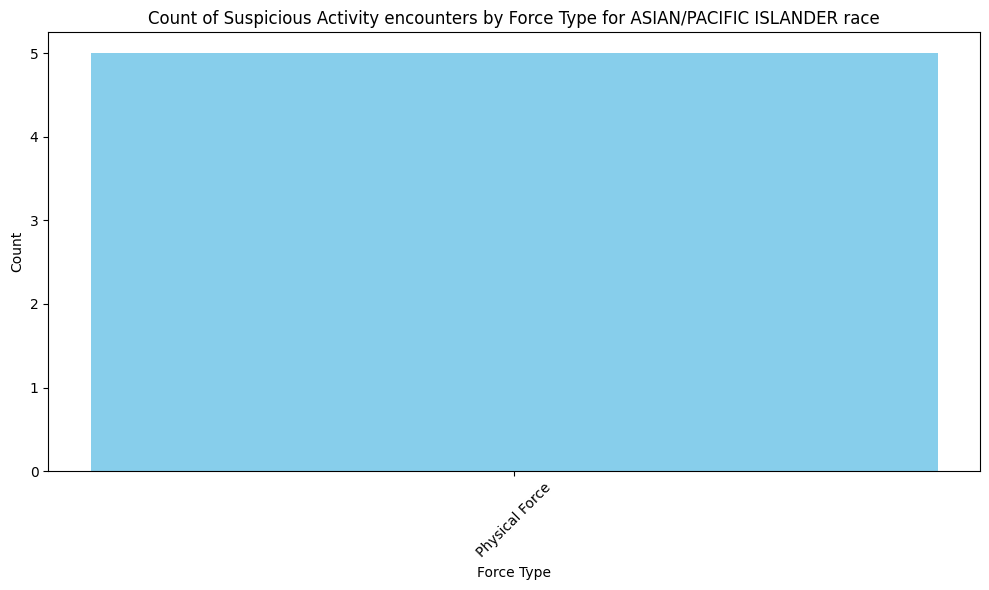

In [26]:
# Filter the DataFrame for race type as 'BLACK' and basis of occurrence as 'SUSPICIOUS ACTIVITY'
filtered_df = use_of_force_combined.filter((col('SUBJECT RACE') == 'ASIAN/PACIFIC ISLANDER') & (col('BasisForEncounter') == 'SUSPICIOUS ACTIVITY'))

# Group by 'ForceType' and count occurrences
force_type_counts = filtered_df.groupBy('ForceType').count().orderBy('count')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
force_type_counts_pd = force_type_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(force_type_counts_pd['ForceType'], force_type_counts_pd['count'], color='skyblue')
plt.xlabel('Force Type')
plt.ylabel('Count')
plt.title('Count of Suspicious Activity encounters by Force Type for ASIAN/PACIFIC ISLANDER race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()